In [73]:
import numpy as np
import cv2
import os
import tensorflow as tf

In [74]:
path = "C:\\Users\\Cordu\\anime faces\\"
images = np.empty([len(os.listdir(path)),64,64,3])
i = 0

for file in os.listdir(path):
    image = cv2.imread(path + file)
    img = cv2.resize(image,(64,64))
    im_array = np.asarray(img) / 255
    images[i] = im_array
    i = i + 1

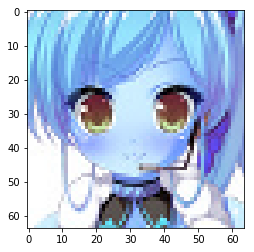

In [75]:
import matplotlib.pyplot as plt

im = images[540]
plt.imshow(im)

In [76]:
import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Activation
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose, GaussianNoise, InputLayer

In [77]:
def create_generator():
    epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
    noise_shape = (100,)

    model = Sequential()

    model.add(Dense(4*4*512, activation='linear', input_shape=(100,)))
    model.add(Reshape((4, 4, 512)))

    model.add(Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(256, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(128, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(64, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(3, kernel_size=[5,5], strides=[1,1], padding="same",
                              kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
    # Standard activation for the generator of a GAN
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

generator = create_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 256)       1638656   
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 256)       1024      
__________

In [78]:
def build_discriminator():

    model = Sequential()

    model = Sequential()
    model.add(InputLayer(input_shape=(64,64,3)))
    model.add(GaussianNoise(0.2))
    model.add(Conv2D(32, (3, 3), strides=[2,2],padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Conv2D(64, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Conv2D(128, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Conv2D(256, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Conv2D(512, (3, 3),strides=[2,2], kernel_initializer='he_uniform', padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
        
    model.summary()
        
    img = Input(shape=(64,64,3))
    validity = model(img)

    return Model(img, validity)

discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_3 (GaussianNo (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
__________

In [79]:
def get_gan():
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.summary()
    
    return model

gan = get_gan()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 64, 64, 3)         6774915   
_________________________________________________________________
model_5 (Model)              (None, 1)                 1574593   
Total params: 8,349,508
Trainable params: 8,346,116
Non-trainable params: 3,392
_________________________________________________________________


In [80]:
optimizer = Adam(0.0002,0.5)
discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
discriminator.trainable = False
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [92]:
from keras.models import load_model

discriminator = load_model('weeb_discriminator.h5')
generator = load_model('weeb_generator.h5')

C:\Users\Cordu\Anaconda3\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [93]:
from PIL import Image

def save_images(epoch):
        noise = np.random.normal(0, 1, [100, 100])
        image_array = np.empty([25,64,64,3])
        gen_imgs = generator.predict(noise)
        image_count = 0
        for i in range(5):
                image_array[i] = gen_imgs[i]
                im = np.asarray(image_array[i] * 255)
                cv2.imwrite("C:\\Users\\Cordu\\animeGirls\\image_%d.png" % (epoch + i) ,im)

In [94]:

epochs = 90000
batch_size = 256
d_loss = [0,0]
g_loss = 0
mean_d_loss=[0,0]
mean_g_loss=0

def train_stuff():
    d_loss = [0,0]
    g_loss = 0
    for i in range(epochs):
        noise= np.random.normal(0,1, [64, 100])
        fake_images = generator.predict(noise)
        fake_output = np.full((64, 1), 0.9)
        indexes = np.random.randint(0, len(os.listdir(path)), 64)
        real_images = images[indexes]
        real_output = np.ones((64,1))
        d_loss = np.add(d_loss, discriminator.train_on_batch(fake_images, fake_output))
        d_loss = np.add(d_loss, discriminator.train_on_batch(real_images, real_output))
        d_loss = d_loss * 0.5
        noise= np.random.normal(0,1, [128, 100])
        g_loss += gan.train_on_batch(noise,np.full((128, 1), 1))
        if i % 100 == 0:
            print(d_loss)
            print(g_loss)
            d_loss = [0,0]
            g_loss = 0
            save_images(i)
        if i % 1000 == 0:
            discriminator.save('weeb_discriminator.h5')  # creates a HDF5 file 'my_model.h5'
            generator.save('weeb_generator.h5')

                           
train_stuff()

[0.19928471 0.5       ]
0.05224137008190155
[0.37308773 1.        ]
3.9360683131963015
[0.34267874 1.        ]
1.3402594244107604
[0.33822645 1.        ]
0.8620860776863992
[0.33189915 1.        ]
0.7147603444755077
[0.331126 1.      ]
0.6410975828766823
[0.33072294 1.        ]
0.5921133356168866
[0.32915252 1.        ]
0.5559206497855484
[0.32909196 1.        ]
0.5285538895986974
[0.32887951 1.        ]
0.5048150508664548
[0.32892983 1.        ]
0.4874031823128462
[0.32721603 1.        ]
0.4708791635930538
[0.3287913 1.       ]
0.45487113995477557
[0.32819345 1.        ]
0.43960709031671286
[0.32733791 1.        ]
0.4268228951841593
[0.32767337 1.        ]
0.4159710882231593
[0.32703404 1.        ]
0.40733490977436304
[0.32790373 1.        ]
0.400107964174822
[0.32691221 1.        ]
0.3934178666677326
[0.32775205 1.        ]
0.3847640110179782
[0.32698494 1.        ]
0.37909396388567984
[0.32651471 1.        ]
0.371780916582793
[0.32631954 1.        ]
0.3676060545258224
[0.32735145 1.

[0.32516226 1.        ]
0.24363307724706829
[0.32516262 1.        ]
0.24470427841879427
[0.32516932 1.        ]
0.2445659409277141
[0.32521573 1.        ]
0.24436350725591183
[0.32519925 1.        ]
0.2461617619264871
[0.32518956 1.        ]
0.24419335718266666
[0.32519432 1.        ]
0.2445190823636949
[0.32521544 1.        ]
0.24444524268619716
[0.32517261 1.        ]
0.24286054214462638
[0.32532193 1.        ]
0.24377413536421955
[0.3251779 1.       ]
0.24354206561110914
[0.32520246 1.        ]
0.24462651554495096
[0.3251617 1.       ]
0.2440833782311529
[0.32517507 1.        ]
0.24401425221003592
[0.32517829 1.        ]
0.2456642973702401
[0.32516874 1.        ]
0.24436764791607857
[0.32517069 1.        ]
0.24244120717048645
[0.32516109 1.        ]
0.24408271489664912
[0.32519527 1.        ]
0.24385401490144432
[0.32518347 1.        ]
0.2437379863113165
[0.32522609 1.        ]
0.24357423558831215
[0.32518547 1.        ]
0.24248095857910812
[0.32519851 1.        ]
0.2440242702141404

[0.32517486 1.        ]
0.23579896427690983
[0.32513443 1.        ]
0.2379194824025035
[0.32513702 1.        ]
0.23707219678908587
[0.32524145 1.        ]
0.23729990934953094
[0.32513672 1.        ]
0.23748940834775567
[0.32514629 1.        ]
0.23764717229641974
[0.32516728 1.        ]
0.23764864029362798
[0.32520234 1.        ]
0.23704172996804118
[0.3251725 1.       ]
0.23593937791883945
[0.32518703 1.        ]
0.23623715830035508
[0.32514271 1.        ]
0.23718435736373067
[0.3251562 1.       ]
0.23496298678219318
[0.3251476 1.       ]
0.2367879191879183
[0.32514625 1.        ]
0.235851698089391
[0.32514848 1.        ]
0.2358714563306421
[0.32516362 1.        ]
0.23663478414528072
[0.32516047 1.        ]
0.23644216684624553
[0.32513951 1.        ]
0.23751849541440606
[0.32514137 1.        ]
0.2375213976483792
[0.32514828 1.        ]
0.2357006601523608
[0.32513854 1.        ]
0.23614076781086624
[0.32522875 1.        ]
0.2364905560389161
[0.32515128 1.        ]
0.2354180053807795
[0.

[0.32513596 1.        ]
0.23458926402963698
[0.32514946 1.        ]
0.23292553331702948
[0.32514814 1.        ]
0.23302566935308278
[0.32514923 1.        ]
0.23265640577301383
[0.32512867 1.        ]
0.23255980713292956
[0.32512577 1.        ]
0.23340829112567008
[0.32514269 1.        ]
0.23325422406196594
[0.32514481 1.        ]
0.23286848538555205
[0.32514648 1.        ]
0.2339828247204423
[0.3251274 1.       ]
0.23436215403489769
[0.32512783 1.        ]
0.23369829286821187
[0.32513572 1.        ]
0.2328149660024792
[0.32515448 1.        ]
0.23332597315311432
[0.32513578 1.        ]
0.2338167247362435
[0.3251305 1.       ]
0.23283671610988677
[0.32513112 1.        ]
0.2331395533401519
[0.32514723 1.        ]
0.23235990526154637
[0.32519223 1.        ]
0.23303084238432348
[0.32513323 1.        ]
0.23181015229783952
[0.32513982 1.        ]
0.23417821829207242
[0.32515681 1.        ]
0.2319920735899359
[0.32513559 1.        ]
0.23229496856220067
[0.32513165 1.        ]
0.233062064973637

[0.32511717 1.        ]
0.229326912201941
[0.32511805 1.        ]
0.23085379763506353
[0.32513388 1.        ]
0.2311637345701456
[0.32513753 1.        ]
0.23131690290756524
[0.32512095 1.        ]
0.23096019448712468
[0.3251271 1.       ]
0.23110243771225214
[0.32512868 1.        ]
0.2318904611747712
[0.32512168 1.        ]
0.23155316524207592
[0.32512012 1.        ]
0.231429404579103
[0.3251401 1.       ]
0.23087653168477118
[0.32512994 1.        ]
0.23098856303840876
[0.32511434 1.        ]
0.23109850846230984
[0.32511712 1.        ]
0.23064464842900634
[0.32514473 1.        ]
0.22970718634314835
[0.32513292 1.        ]
0.23026311281137168
[0.32512193 1.        ]
0.23062404803931713
[0.32513793 1.        ]
0.2316314505878836
[0.32512765 1.        ]
0.23162353760562837
[0.32512994 1.        ]
0.2318788815755397
[0.32511534 1.        ]
0.23029908747412264
[0.32511588 1.        ]
0.23120322986505926
[0.32515944 1.        ]
0.2309154039248824
[0.32513308 1.        ]
0.2298998194746673
[0